In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from AvaliacaoModelo import AvaliacaoModelo
from modelos.CFRecommender import *
from modelos.PopularityRecommender import PopularityRecommender
from modelos.CFRecommenderSVD import *

# Etapa de Pre-processamento

In [3]:
ratings = pd.read_csv('dataset/BX-Book-Ratings.csv', encoding='ISO-8859-1', delimiter=';')
books = pd.read_csv('dataset/BX-Books.csv', encoding='ISO-8859-1', delimiter=';', error_bad_lines=False)
users = pd.read_csv('dataset/BX-Users.csv', encoding='ISO-8859-1', delimiter=';')

b'Skipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\Users\aleff.neves.ACOCEARENSE\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:30

In [4]:
books = books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1)

book_rating = pd.merge(ratings, books, on='ISBN', how='inner')

book_rating = pd.merge(book_rating,users, on='User-ID', how='inner')

book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"tyler, texas, usa",NaN
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"cincinnati, ohio, usa",23.0
2,2313,0812533550,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,"cincinnati, ohio, usa",23.0
3,2313,0679745580,8,In Cold Blood (Vintage International),TRUMAN CAPOTE,1994,Vintage,"cincinnati, ohio, usa",23.0
4,2313,0060173289,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,1996,HarperCollins,"cincinnati, ohio, usa",23.0


Removendo todos os ratings iguais a zero e usuários que avaliaram menos de 4 vezes, com o intuito de criar uma matrix menos esparça

In [5]:
book_rating = book_rating[book_rating['Book-Rating']> 0]

# filtrando apenas os livros que foram avaliados mais de 9 vezes
ratings_full = book_rating.groupby('ISBN').filter(lambda x: len(x) >= 10)

# filtrando apenas os usuário que avaliaram mais de 3 vezes
ratings_full = ratings_full.groupby('User-ID').filter(lambda x: len(x) >= 4)

In [6]:
ratings_full = ratings_full.groupby(['ISBN', 'User-ID'])['Book-Rating'].mean().to_frame().reset_index()

In [7]:
ratings_full.head()

,ISBN,User-ID,Book-Rating
0,0002558122,11676,8
1,0002558122,81274,8
2,0002558122,201537,8
3,000648302X,11676,8
4,000648302X,37950,9


In [8]:
#Persistindo a base processada
ratings_full.to_csv('dataset/ratings_full.csv')

# Treinamento dos modelos

In [9]:
ratings_full = pd.read_csv('dataset/ratings_full.csv', index_col=0)
ratings_full.head()

,ISBN,User-ID,Book-Rating
0,0002558122,11676,8
1,0002558122,81274,8
2,0002558122,201537,8
3,000648302X,11676,8
4,000648302X,37950,9


In [10]:
ratings_train, ratings_test = train_test_split(ratings_full,test_size=0.20,stratify=ratings_full['User-ID'], random_state=42)

print('# avaliações de treino: %d' % len(ratings_train))
print('# avaliações no teste: %d' % len(ratings_test))

# avaliações de treino: 77037
# avaliações no teste: 19260


In [11]:
ratings_full_index = ratings_full.set_index('User-ID')
ratings_test_index = ratings_test.set_index('User-ID')
ratings_train_index = ratings_train.set_index('User-ID')

In [12]:
#Instanciando as classes dos modelos
modelo_popularidade = PopularityRecommender(ratings_full, book_rating)
treinamento_cf = CFTraing()
treinamento_svd = CFTraingSVD()

In [13]:
#Treinando os modelos colaborativos, o modelo de popularidade não precisa ser treinado
modelo_CF = CFRecommender(treinamento_cf.training_model(ratings_train), book_rating)
modelo_CF_SVD = CFRecommenderSVD(treinamento_svd.training_model(ratings_full, 20), book_rating)

# Avaliação dos modelos

In [14]:
#Instanciando a classe de avaliação dos modelos
avaliacao_modelo = AvaliacaoModelo(ratings_test_index,ratings_train_index)

In [15]:
print('Avaliando modelo de popularidade...')
pop_global_metrics, pop_detailed_results_df = avaliacao_modelo.avaliar_modelo(modelo_popularidade)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Avaliando modelo de popularidade...
7460 usuários processados

Global metrics:
{'modelName': 'Popularidade', 'recall@5': 5.1921079958463136e-05, 'recall@10': 0.00015576323987538941}


,_user_id,avaliacoes_count,hits@10_count,hits@5_count,recall@10,recall@5
53,11676,379,0,0,0.0,0.0
102,16795,68,0,0,0.0,0.0
248,98391,63,0,0,0.0,0.0
95,153662,60,0,0,0.0,0.0
79,95359,57,0,0,0.0,0.0
189,104636,54,0,0,0.0,0.0
143,114368,53,0,0,0.0,0.0
658,123883,41,0,0,0.0,0.0
604,60244,41,0,0,0.0,0.0
222,158295,40,0,0,0.0,0.0


In [16]:
print('Avaliando modelo de filtros colaborativos...')
cf_global_metrics, cf_detailed_results_df = avaliacao_modelo.avaliar_modelo(modelo_CF)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Avaliando modelo de filtros colaborativos...
7460 usuários processados

Global metrics:
{'modelName': 'Filtros Colaborativos', 'recall@5': 0.05893042575285566, 'recall@10': 0.08452751817237798}


,_user_id,avaliacoes_count,hits@10_count,hits@5_count,recall@10,recall@5
53,11676,379,2,1,0.005277,0.002639
102,16795,68,1,1,0.014706,0.014706
248,98391,63,1,0,0.015873,0.000000
95,153662,60,1,1,0.016667,0.016667
79,95359,57,2,2,0.035088,0.035088
189,104636,54,3,1,0.055556,0.018519
143,114368,53,2,1,0.037736,0.018868
658,123883,41,4,2,0.097561,0.048780
604,60244,41,0,0,0.000000,0.000000
222,158295,40,1,1,0.025000,0.025000


In [17]:
print('Avaliando modelo de filtros colaborativos SVD...')
svd_global_metrics, svd_detailed_results_df = avaliacao_modelo.avaliar_modelo(modelo_CF_SVD)
print('\nGlobal metrics:\n%s' % svd_global_metrics)
svd_detailed_results_df.head(10)

Avaliando modelo de filtros colaborativos SVD...
7460 usuários processados

Global metrics:
{'modelName': 'Filtros Colaborativos SVD', 'recall@5': 0.08468328141225337, 'recall@10': 0.11973001038421599}


,_user_id,avaliacoes_count,hits@10_count,hits@5_count,recall@10,recall@5
53,11676,379,10,5,0.026385,0.013193
102,16795,68,8,4,0.117647,0.058824
248,98391,63,10,5,0.158730,0.079365
95,153662,60,10,5,0.166667,0.083333
79,95359,57,10,5,0.175439,0.087719
189,104636,54,10,5,0.185185,0.092593
143,114368,53,9,5,0.169811,0.094340
658,123883,41,5,4,0.121951,0.097561
604,60244,41,5,2,0.121951,0.048780
222,158295,40,1,1,0.025000,0.025000


In [18]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, svd_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@10,recall@5
modelName,,
Popularidade,0.000156,0.000052
Filtros Colaborativos,0.084528,0.058930
Filtros Colaborativos SVD,0.119730,0.084683


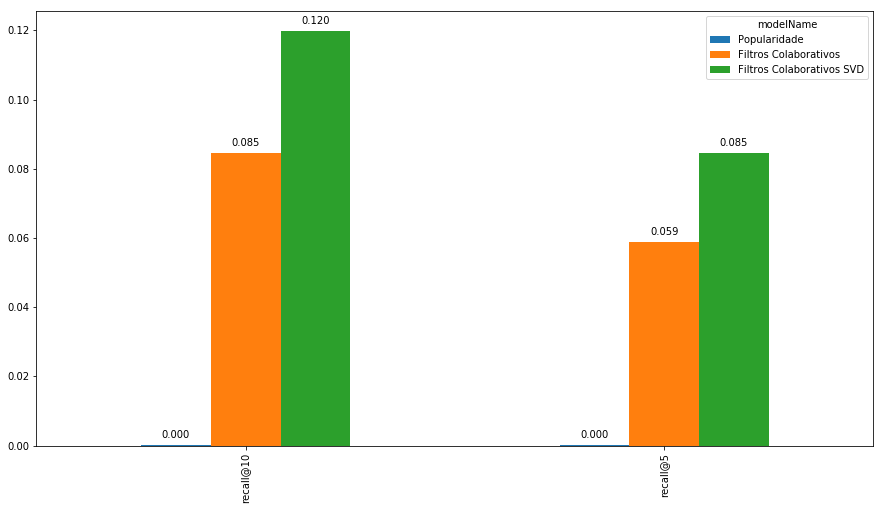

In [19]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')